### Notebook for the label transfer of healthy skin to infected skin using `scANVI`

- **Developed by:** Anna Maguza
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date:** 27th December 2023

### Import required modules

In [7]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

### Set up working environment

In [8]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [9]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [10]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

In [11]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in Healthy data

In [12]:
SCC0120_1_Skin = sc.read_h5ad('data_skin/SCC0120_1_Skin_scANVI_annot_Anna.h5ad')
SCC0120_1_Skin

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'total_counts

In [13]:
X_is_raw(SCC0120_1_Skin)

False

In [19]:
SCC0120_1_Skin.obs['condition'].cat.categories

Index(['healthy', 'infected'], dtype='object')

In [21]:
SCC0120_1_HS = SCC0120_1_Skin[SCC0120_1_Skin.obs['condition'].isin(['healthy'])]
SCC0120_1_HS

View of AnnData object with n_obs × n_vars = 3532 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'tota

In [22]:
SCC0120_1_IS = SCC0120_1_Skin[SCC0120_1_Skin.obs['condition'].isin(['infected'])]
SCC0120_1_IS

View of AnnData object with n_obs × n_vars = 3947 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'tota

In [23]:
SCC0120_1_HS.obs['seed_labels'] = SCC0120_1_HS.obs['C_scANVI'].copy()
SCC0120_1_IS.obs['seed_labels'] = 'Unknown'

In [24]:
adata = SCC0120_1_HS.concatenate(SCC0120_1_IS, batch_key = 'skin_condition', batch_categories = ['healthy', 'infected'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_sk

- Save raw counts

In [25]:
adata.raw = adata

In [26]:
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown                3947
Pericyte_1             1315
Tc                      467
Th                      418
F1                      397
VE1                     205
VE2                     188
Melanocyte               93
F2                       90
Treg                     73
ILC1_3                   68
Mono_mac                 68
moDC                     47
LE2                      40
Macro_1                  31
Differentiated_KC        16
Undifferentiated_KC      14
migLC                     2
Name: count, dtype: int64

### Select HVGs

In [27]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 7479 × 7000
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_ski

### Transfer of annotation with scANVI

In [28]:
scvi.model.SCVI.setup_anndata(adata,
                        batch_key = 'donor',
                        labels_key = 'seed_labels',
                        categorical_covariate_keys = ['donor', 'batch'],                    
                        continuous_covariate_keys = ['n_genes', 'n_counts'], 
                        layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [29]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3,
                             dispersion = 'gene-batch',
                             gene_likelihood = 'nb')

In [30]:
scvi_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|█| 400/400 [02:02<00:00,  3.36it/s, v_num=1, train_loss_step=2.97e+3, train_loss_epoc

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [02:02<00:00,  3.25it/s, v_num=1, train_loss_step=2.97e+3, train_loss_epoc


### Label transfer with `scANVI` 

In [31]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [32]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 10/10: 100%|█| 10/10 [00:09<00:00,  1.07it/s, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█| 10/10 [00:09<00:00,  1.09it/s, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.


In [33]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [34]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [35]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


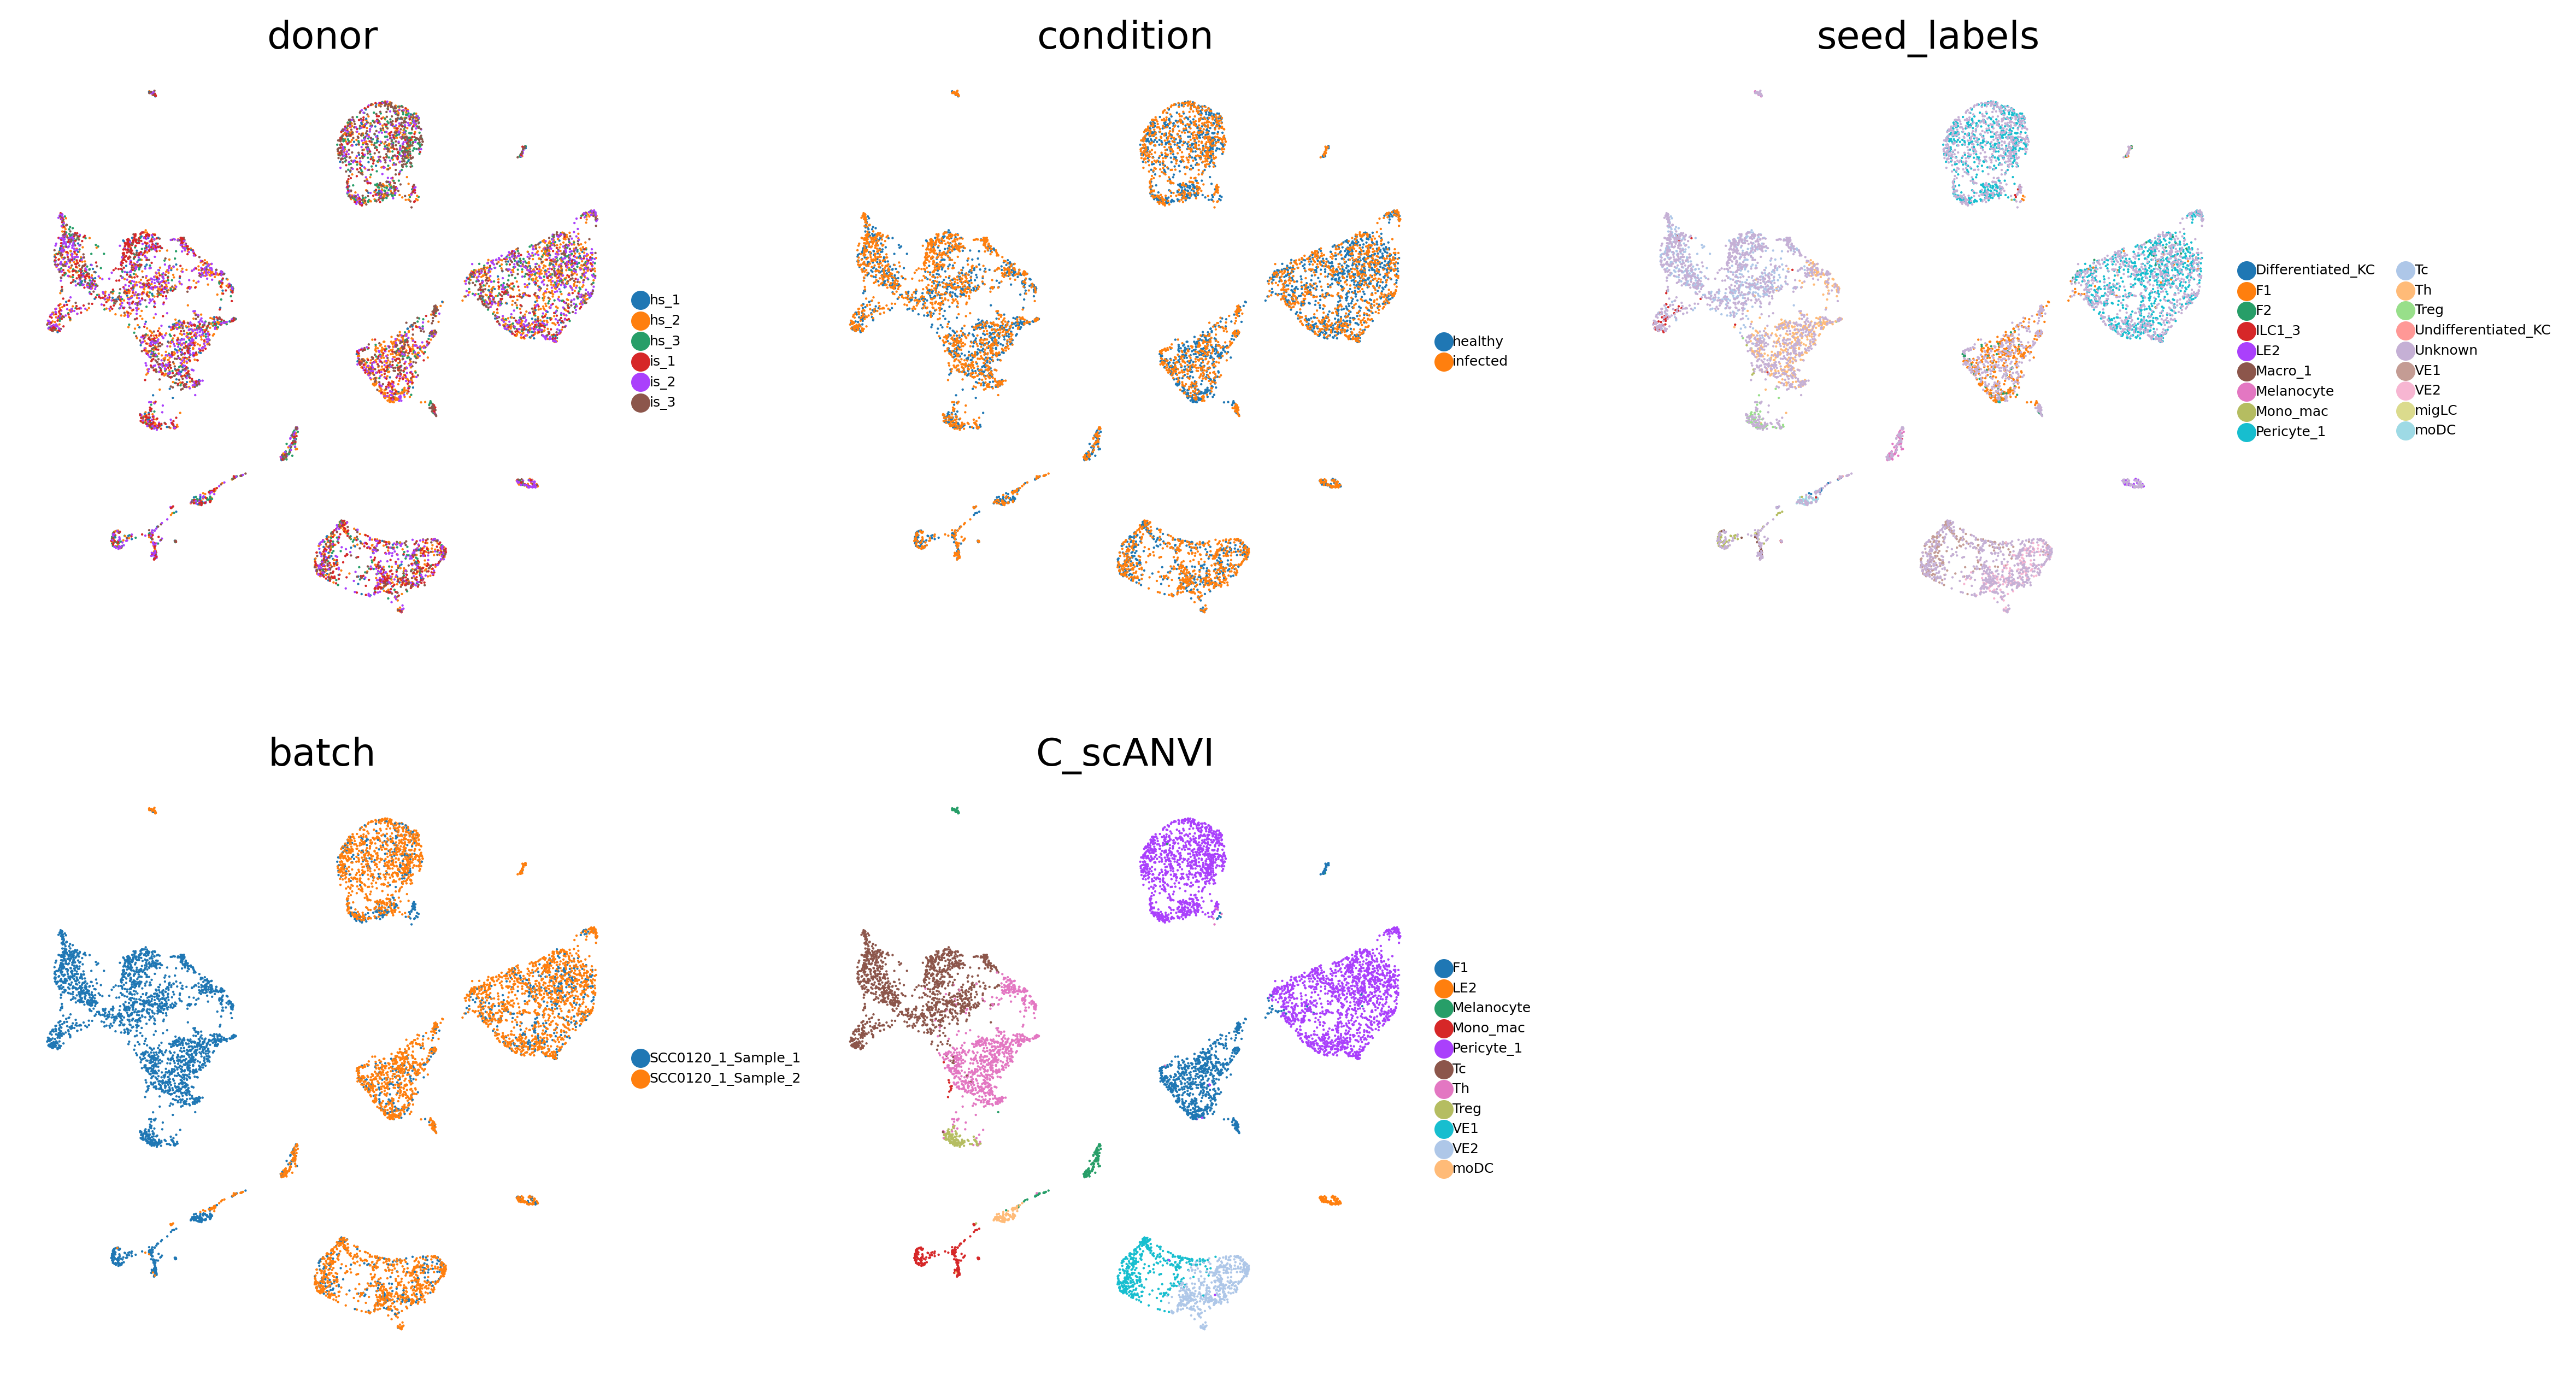

In [36]:
sc.pl.umap(adata, frameon = False, color = ['donor', 'condition', 'seed_labels', 'batch', 'C_scANVI'], size = 3, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [37]:
adata_skin = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs, obsm = adata.obsm) 
adata_skin

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_sk

In [38]:
SCC0120_1_skin_annotated = adata_skin[adata_skin.obs['group'].isin(['SCC0120_1_skin'])]
SCC0120_1_skin_annotated

View of AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0

In [39]:
SCC0120_1_skin_annotated.write('data_skin/SCC0120_1_Skin_scANVI_states_Anna.h5ad')